# Circular flow in a district heating grid

This example demonstrates how to model and analyze a simple district heating network with a circular flow using pandapipes.

The network consists of a pump (representing a heat generator) that supplies hot water, which flows through consumers (heat exchangers), releases heat, and then returns to the pump. In addition to pressure and velocity distribution, the temperature profile throughout the network is also calculated. Due to heat losses and heat extraction by the consumer, the temperature will decrease along the flow path. Understanding these temperature drops is crucial for energy efficiency and proper system design in district heating networks.


<img src="../pics/district_heating/simple_district_heating_net_text.png">

## Network Setup

To set up this network, first import the pandapipes package. Additionally, create a net container and select water as the working fluid.

In [104]:
import pandapipes as pp

# create empty net
net = pp.create_empty_network(fluid ="water")

## Junctions

Note that the flow in this example network forms a closed loop. We will use four junctions for this demonstration. The parameters `pn_bar` (pressure) and `tfluid_k` (temperature) set in the `create_junction` function are only used as initial values for the network simulation. It is recommended to initialize the network with the flow temperature of the supplying pump. The actual pressure and fluid temperature are determined by the circular pump component, which will be created afterwards. For more complex networks, the number of junctions can be easily adapted.

In [105]:
j0 = pp.create_junction(net, pn_bar=4, tfluid_k=293.15, name="junction 0", geodata=(0, 0))
j1 = pp.create_junction(net, pn_bar=4, tfluid_k=293.15, name="junction 1", geodata=(0, 10))
j2 = pp.create_junction(net, pn_bar=4, tfluid_k=293.15, name="junction 2", geodata=(10, 10))
j3 = pp.create_junction(net, pn_bar=4, tfluid_k=293.15, name="junction 3", geodata=(10, 0))

## Circ Pump Const Pressure

Now, the pump will be created. For a simple district heating network, the `circ_pump_const_pressure` component is used. This type of pump requires a flow pressure, a pressure lift, and a flow temperature as input. The mass flow is calculated during the pipeflow calculation by solving the mass balance in the network.

The pressure lift represents the energy added to the fluid by the pump to overcome losses and supply the network with sufficient pressure.

Note that the circular pump is a component which internally consists of an external grid (connected to the junction specified via the `from_junction` parameter) and a sink (connected to the junction specified via the `to_junction` parameter). However, this internal structure is not visible to the user, so the circular pump const pressure component supplies a fluid flow with the specified properties.

In [106]:
pp.create_circ_pump_const_pressure(net, return_junction=j0, flow_junction=j1, p_flow_bar=4, plift_bar=1.5, t_flow_k=273.15+70,
                                    type="auto", name="const_pressure_pump", index=None, in_service=True)

0

## Heat Consumer

Next, the heat consumer component is created.
The key parameter for this component is the heat flux `qext_w`. A positive value of `qext_w` means that heat is withdrawn from the network and supplied to a consumer. A negative value of `qext_w` corresponds to a heat source, i.e., thermal energy is transferred from the heat exchanger into the network.

The behavior of the heat consumer can be further specified using the following parameters:

- If `treturn_k` (return temperature) is defined, no other parameter should be set. The system will then calculate the resulting mass flow in the heat consumer based on the transferred heat.
- If `controlled_mdot_kg_per_s` (controlled mass flow) is specified, a fixed mass flow is set in the heat consumer, and the temperatures are calculated by solving the mass and energy balances.
- If `deltat_k` (temperature difference) is used, a fixed temperature drop is set for the heat consumer, enabling the calculation of both mass flow and return temperature.


In [107]:
pp.create_heat_consumer(net, from_junction=j2, to_junction=j3, qext_w=10000, controlled_mdot_kg_per_s=None,
                         deltat_k=None, treturn_k=50, name=None, index=None, in_service=True, type="heat_consumer")
#pp.create_heat_consumer(net, from_junction=j2, to_junction=j3, qext_w=10000, controlled_mdot_kg_per_s=2,
#                         deltat_k=None, treturn_k=None, name=None, index=None, in_service=True, type="heat_consumer")
#pp.create_heat_consumer(net, from_junction=j2, to_junction=j3, qext_w=10000, controlled_mdot_kg_per_s=None,
#                         deltat_k=10, treturn_k=None, name=None, index=None, in_service=True, type="heat_consumer")

0

## Pipes

The following commands define the pipes between the components. Each pipe will consist of (in this case) five internal sections to improve the spatial resolution for the temperature calculation. Increasing the number of sections improves the accuracy of the temperature profile, but also increases computation time.

The parameter `text_k` specifies the ambient temperature on the outside of the pipe and is used to calculate energy losses. `k_mm` defines the roughness in the pipe, which is used in the pressure drop calculation.

In [108]:
pp.create_pipe(net, from_junction=j1, to_junction=j2, std_type="110/202 PLUS", length_km=1, k_mm=0.1, loss_coefficient=0,
               sections=5, text_k=283, qext_w=0., name="pipe_0_1", index=None, geodata=None, in_service=True, type="pipe")
pp.create_pipe(net, from_junction=j3, to_junction=j0, std_type="110/202 PLUS", length_km=1, k_mm=0.1, loss_coefficient=0,
               sections=5, text_k=283, qext_w=0., name="pipe_1_2", index=None, geodata=None, in_service=True, type="pipe")

1

## Plotting Net

The following command creates a simple plot of the network layout using `pandapipes.plotting.simple_plot`. 
This visualization helps to understand the structure and connectivity of the district heating grid, showing the positions of junctions, pipes, pumps, and consumers.

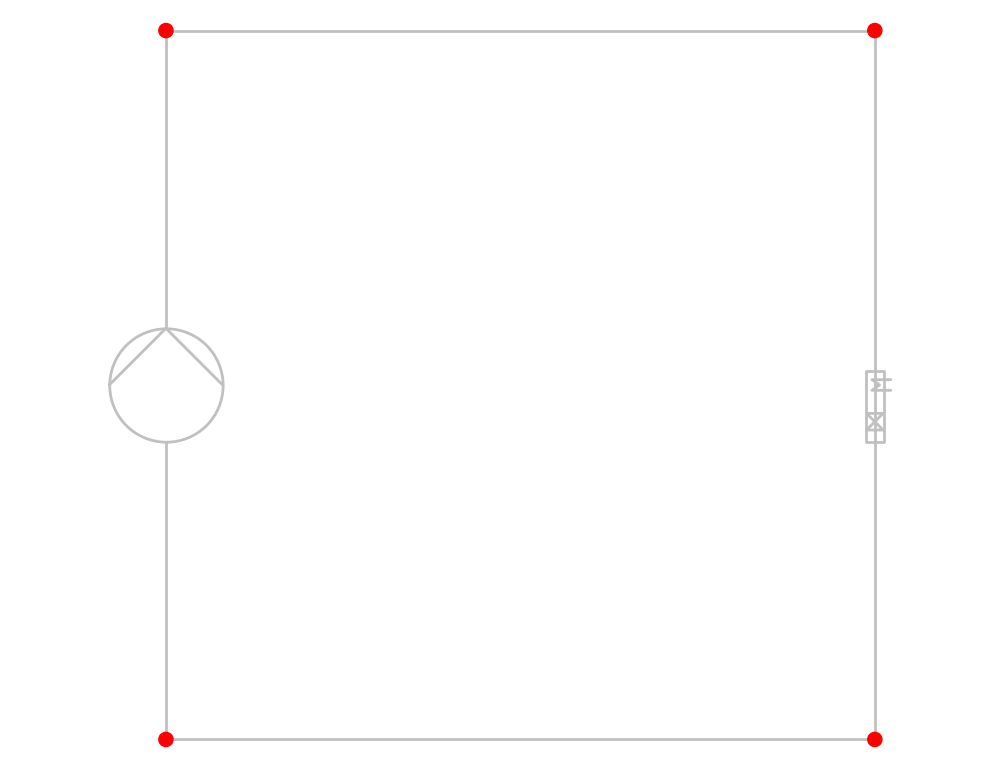

<Axes: >

In [109]:
pp.plotting.simple_plot(net)

## Pipeflow Calculation

We now run a pipe flow calculation using the bidirectional calculation mode. This mode is especially important for networks with heat exchange, as it enables the simultaneous calculation of hydraulic and thermal behavior.

In [110]:
pp.pipeflow(net, mode='bidirectional', iter=100)

By default, only the pressure and velocity distribution is calculated by the `pipeflow` function. If the `mode` parameter is set to "bidirectional", the heat transfer calculation is started automatically after the hydraulics computation. Computed mass flows are used as input for the temperature calculation.

## Results

After the computation, you can check the results for junctions and pipes.

Tip: If you observe unexpected results, such as negative temperatures, check the extracted heat flow and ambient temperature settings.

In [111]:
net.res_junction

,p_bar,t_k
0,2.500000,225.464713
1,4.000000,343.150000
2,3.999974,297.097587
3,2.500303,50.000000


Note that a constant heat flow is extracted via the heat consumer between nodes 1 and 2. Heat losses due to the ambient temperature are not taken into account in the heat consumer; these are only included in the pipe components. This also means that, if the extracted heat flow is large enough, the temperature level behind the heat consumer might be lower than the ambient temperature. To avoid this behavior, you could create a controller that defines a function for the extracted heat depending on the ambient temperature.

Tip: For larger networks, consider visualizing the results to better understand the temperature and pressure distribution throughout the system.

In [112]:
net.res_pipe

,v_mean_m_per_s,p_from_bar,p_to_bar,t_from_k,t_to_k,t_outlet_k,mdot_from_kg_per_s,mdot_to_kg_per_s,vdot_m3_per_s,reynolds,lambda
0,0.001181,4.000000,3.999974,343.15,297.097587,297.097587,0.009375,-0.009375,0.000009,189.304289,0.376229
1,0.001173,2.500303,2.500000,50.00,225.464713,225.464713,0.009375,-0.009375,0.000009,16.052576,4.459393


The command above shows the results for the pipe components. The temperatures of the adjacent
junctions are displayed. Due to heat losses, the temperatures at the to-nodes is lower than the
temperatures at the from-nodes. Note also that the junctions are not equal to the internal nodes,
introduced by the pipe sections we defined. To display the temperatures at the internal nodes, we
can retrieve the internal node values with the following commands:

## Plotting Results

In [113]:
from pandapipes.component_models import Pipe
pipe_results = Pipe.get_internal_results(net, [0])

The parameters of the get_internal_results function correspond to the net and the pipes we want to
evaluate. In this case, only the results of pipe zero are retrieved. The returned value stored in
pipe_results is a dictionary, containing fields for the pressure, the velocity and the temperature.
The dictionary can either be used for own evaluations now or it can be used to plot the results over
the pipe length:


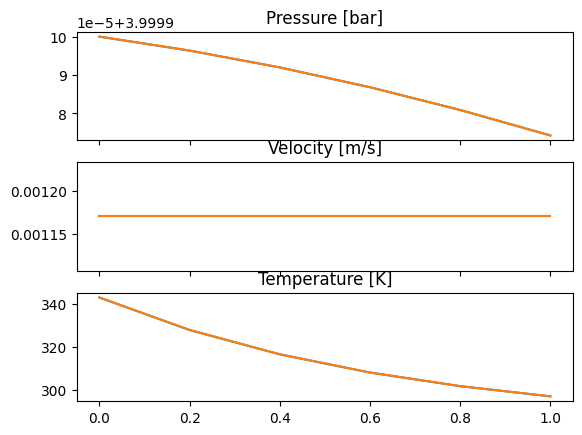

In [114]:
Pipe.plot_pipe(net, 0, pipe_results)

We can see that the pressure level falls due to friction. As the fluid is incompressible, the
velocity remains constant over the pipe length. Because the temperature level at the pipe entry is
higher than the ambient temperature, the temperature level decreases.

## More Examples

Further examples for closed district heating networks can be found in the notebooks:  
- `multiple_pumps_flow_in_a_circular_district_heating_grid.ipynb`  
- `time_series_in_a_circular_district_heating_grid.ipynb`